In [1]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.Sarimax import Sarimax
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima #SARIMAX using pmdarima
from skforecast.ForecasterSarimax import ForecasterSarimax

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation

import joblib



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set display option to show all rows and columns
pd.set_option('display.max_rows', None)  # No row limit
pd.set_option('display.max_columns', None)  # No column limit
pd.set_option('display.width', None)  # No line width limit
pd.set_option('display.max_colwidth', None)  # Show full column width

SARIMAX for Mindanao
DATA PREPROCESSING

In [3]:
labels_csv = r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Mindanao/train_labels_transformed.csv'
data_csv = r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Mindanao/train_data_transformed.csv'
test_data_csv=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Mindanao/test_data.csv'
test_labels_csv=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Mindanao/test_labels.csv'
transformed_data=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Mindanao/data_transformed.csv'
complete_data = '/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Mindanao/MIN_Daily_Complete.csv'

transformed_train_data = pd.read_csv(data_csv)
transformed_train_labels = pd.read_csv(labels_csv)
transformed_data = pd.read_csv(transformed_data)

test_data = pd.read_csv(test_data_csv)
test_labels = pd.read_csv(test_labels_csv)

complete_data_df = pd.read_csv(complete_data)
gwap = complete_data_df[['GWAP']]
lwap = complete_data_df[['LWAP']]



In [4]:
train_size = int(len(transformed_train_labels))  
test_size = int(len(test_data))

date_range = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
date_df = pd.DataFrame(date_range, columns=['Date'])

train_date = date_df[:train_size]
test_date = date_df[train_size:]

#Resetting the Index
train_date = train_date.reset_index(drop=True)
test_date = test_date.reset_index(drop=True)


In [5]:
#Preparing the dataframes
transformed_train_labels.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)
labels_columns = ['GWAP', 'LWAP']
labels_train = pd.DataFrame(transformed_train_labels, columns = labels_columns)
labels_test = pd.DataFrame(test_labels, columns = labels_columns)

transformed_train_data.rename(columns={'0':'FLOW_MIN', '1':'Hourly Demand', '2':'TMIN_Davao City','3':'TMAX_Surigao','4':'TMIN_Surigao','5':'TMIN_Zamboanga','6':'TMIN_Butuan','7':'TMAX_Malaybalay','8':'TMAX_General Santos', '9':'GWAP', '10':'LWAP','11':'TMAX_Davao City','12':'TMAX_Zamboanga','13':'TMAX_Dipolog','14':'TMIN_Dipolog','15':'TMAX_Butuan','16':'TMIN_Malaybalay','17':'TMAX_Cotabato','18':'TMIN_Cotabato','19':'RESERVE_GWAP_Fr','20':'RESERVE_GWAP_Ru','21':'RESERVE_GWAP_Rd','22':'RESERVE_GWAP_Dr','23':'RAINFALL_Davao City','24':'RAINFALL_Surigao','25':'RAINFALL_Zamboanga','26':'RAINFALL_Dipolog','27':'RAINFALL_Butuan','28':'RAINFALL_Malaybalay','29':'RAINFALL_General Santos','30':'TMIN_General Santos','31':'RAINFALL_Cotabato'}, inplace=True)
data_columns = ['FLOW_MIN', 'Hourly Demand', 'TMIN_Davao City', 'TMAX_Surigao', 'TMIN_Surigao', 'TMIN_Zamboanga', 'TMIN_Butuan', 'TMAX_Malaybalay', 'TMAX_General Santos','GWAP', 'LWAP', 'TMAX_Davao City', 'TMAX_Zamboanga', 'TMAX_Dipolog', 'TMIN_Dipolog', 'TMAX_Butuan', 'TMIN_Malaybalay', 'TMAX_Cotabato', 'TMIN_Cotabato','RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr', 'RAINFALL_Davao City', 'RAINFALL_Surigao', 'RAINFALL_Zamboanga', 'RAINFALL_Dipolog', 'RAINFALL_Butuan', 'RAINFALL_Malaybalay', 'RAINFALL_General Santos', 'TMIN_General Santos', 'RAINFALL_Cotabato']
data_train = pd.DataFrame(transformed_train_data, columns = data_columns)
data_test = pd.DataFrame(test_data, columns = data_columns)

transformed_data.rename(columns={'0':'FLOW_MIN', '1':'Hourly Demand', '2':'TMIN_Davao City','3':'TMAX_Surigao','4':'TMIN_Surigao','5':'TMIN_Zamboanga','6':'TMIN_Butuan','7':'TMAX_Malaybalay','8':'TMAX_General Santos', '9':'GWAP', '10':'LWAP','11':'TMAX_Davao City','12':'TMAX_Zamboanga','13':'TMAX_Dipolog','14':'TMIN_Dipolog','15':'TMAX_Butuan','16':'TMIN_Malaybalay','17':'TMAX_Cotabato','18':'TMIN_Cotabato','19':'RESERVE_GWAP_Fr','20':'RESERVE_GWAP_Ru','21':'RESERVE_GWAP_Rd','22':'RESERVE_GWAP_Dr','23':'RAINFALL_Davao City','24':'RAINFALL_Surigao','25':'RAINFALL_Zamboanga','26':'RAINFALL_Dipolog','27':'RAINFALL_Butuan','28':'RAINFALL_Malaybalay','29':'RAINFALL_General Santos','30':'TMIN_General Santos','31':'RAINFALL_Cotabato'}, inplace=True)

In [7]:
#lagging the transformed data
transformed_data = transformed_data.shift(1)
transformed_data = transformed_data.fillna(0)

#Removing GWAP and LWAP
transformed_exog = transformed_data.drop(columns=['GWAP','LWAP','TMIN_Cotabato'])

#Preparing the exog datasets
train_exog = transformed_exog[:train_size]
test_exog = transformed_exog[train_size:]



In [8]:
#Preparing transformed GWAP datasets
GWAP_train = labels_train['GWAP']
GWAP_train = pd.concat([train_date,GWAP_train], axis=1)
GWAP_train.set_index('Date', inplace=True)
GWAP_train.index = pd.to_datetime(GWAP_train.index)
GWAP_train.index.freq='D'
GWAP_train = GWAP_train.squeeze()


GWAP_test = labels_test['GWAP']
GWAP_test = pd.concat([test_date,GWAP_test], axis=1)
GWAP_test.set_index('Date', inplace=True)
GWAP_test.index = pd.to_datetime(GWAP_test.index)
GWAP_test.index.freq='D'
GWAP_test = GWAP_test.squeeze()

#Preparing original GWAP datasets
GWAP = pd.concat([date_df,gwap], axis=1)
GWAP.set_index('Date', inplace=True)
GWAP.index = pd.to_datetime(GWAP.index)
GWAP.index.freq='D'
GWAP = GWAP.squeeze()

GWAP_test_inversed = GWAP[train_size:]




#Preparing the transformed LWAP datasets
LWAP_train = labels_train['LWAP']
LWAP_train = pd.concat([train_date,LWAP_train], axis=1)
LWAP_train.set_index('Date', inplace=True)
LWAP_train.index = pd.to_datetime(LWAP_train.index)
LWAP_train.index.freq='D'
LWAP_train = LWAP_train.squeeze()

LWAP_test = labels_test['LWAP']
LWAP_test = pd.concat([test_date,LWAP_test], axis=1)
LWAP_test.set_index('Date', inplace=True)
LWAP_test.index = pd.to_datetime(LWAP_test.index)
LWAP_test.index.freq='D'
LWAP_test = LWAP_test.squeeze()

#Preparing the original LWAP datasets

LWAP = pd.concat([date_df,lwap], axis=1)
LWAP.set_index('Date', inplace=True)
LWAP.index = pd.to_datetime(LWAP.index)
LWAP.index.freq='D'
LWAP = LWAP.squeeze()

LWAP_test_inversed = LWAP[train_size:]



#Preparing the exogenous datasets
exog_train = pd.concat([train_date,train_exog], axis=1)
exog_train.set_index('Date', inplace=True)

test_exog = pd.DataFrame(test_exog)
test_exog = test_exog.reset_index()
exog_test = pd.concat([test_date,test_exog], axis=1)
exog_test.set_index('Date', inplace=True)
exog_test = exog_test.drop(columns=['index'])

In [9]:
#Applying the inverse transformations
#Loading inverse transformations for Mindanao

minmax_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Mindanao/minmax_scaler.pkl')
boxcox_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Mindanao/boxcox_pipeline.pkl')
yeojohnson_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Mindanao/yeojohnson_pipeline.pkl')
boxcoxy_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Mindanao/boxcox_pipeliney.pkl')

In [10]:
#Plotting Train LWAP ang GWAP
# Create the line plot
gwap_plot = px.line(GWAP_train, x=GWAP_train.index, y='GWAP')
lwap_plot = px.line(LWAP_train, x=LWAP_train.index, y='LWAP')
# Set the title using the ticker value
gwap_plot.update_layout(title=f"Mindanao GWAP")
lwap_plot.update_layout(title=f"Mindanao LWAP")
# Display the plot
gwap_plot.show()
lwap_plot.show()

In [11]:
def perform_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Check initial stationarity
    for i in range(max_differences):
        adf_p_value = adf_test(data)
        kpss_p_value = kpss_test(data)

        # If ADF p-value is less than 0.05 and KPSS p-value is greater than 0.05, it's stationary
        if adf_p_value < 0.05 and kpss_p_value > 0.05:
            print(f"Data is stationary after differencing {i} times.")
            return data

        # If not stationary, apply differencing
        data = data.diff().dropna()

    print(f"Data could not be made stationary after {max_differences} differencing operations.")
    return data

#same test for dataframe
def perform_df_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS 
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Store in new DataFrame
    diff_exog = pd.DataFrame(index=data.index)

    # Check each column in the DataFrame
    for column in data.columns:
        series = data[column].copy()  # Copy the series to avoid modifying the original

        for i in range(max_differences):
            adf_p_value = adf_test(series)
            kpss_p_value = kpss_test(series)

            # If stationary, break the loop and store the series
            if adf_p_value < 0.05 and kpss_p_value > 0.05:
                print(f"Column '{column}' is stationary after differencing {i} times.")
                diff_exog[column] = series  # Store the stationary series
                break

            # If not stationary, apply differencing
            if i < max_differences - 1:  # Don't drop NA on the last iteration
                series = series.diff().dropna()

        else:  # This else corresponds to the for-loop
            print(f"Column '{column}' could not be made stationary after {max_differences} differencing operations.")
            diff_exog[column] = series  # Store the last differenced result

    return diff_exog


In [12]:
#Checking for stationarity in GWAP data
perform_differencing(GWAP_train)
perform_differencing(LWAP_train)



Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_81484/2411308064.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_81484/2411308064.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Date
2023-01-01    0.572044
2023-01-02    0.226305
2023-01-03    0.432754
2023-01-04    0.394590
2023-01-05    0.791064
2023-01-06    0.897758
2023-01-07    0.553324
2023-01-08    0.191077
2023-01-09    0.685804
2023-01-10    0.540832
2023-01-11    0.359720
2023-01-12    0.009394
2023-01-13    0.043903
2023-01-14    0.044297
2023-01-15    0.453811
2023-01-16    0.312132
2023-01-17    0.253908
2023-01-18    0.324166
2023-01-19    0.263327
2023-01-20    0.141918
2023-01-21    0.409912
2023-01-22    0.000000
2023-01-23    0.006489
2023-01-24    0.065520
2023-01-25    0.164384
2023-01-26    0.327889
2023-01-27    0.402638
2023-01-28    0.427732
2023-01-29    0.216442
2023-01-30    0.371193
2023-01-31    0.442240
2023-02-01    0.469025
2023-02-02    0.472848
2023-02-03    0.508227
2023-02-04    0.456497
2023-02-05    0.425932
2023-02-06    0.514594
2023-02-07    0.480097
2023-02-08    0.456198
2023-02-09    0.454993
2023-02-10    0.482379
2023-02-11    0.477533
2023-02-12    0.397990
2023-0

In [13]:
diff_exog_train = perform_df_differencing(exog_train)
diff_exog_train = diff_exog_train.fillna(0)

Column 'FLOW_MIN' is stationary after differencing 1 times.
Column 'Hourly Demand' is stationary after differencing 1 times.
Column 'TMIN_Davao City' is stationary after differencing 1 times.
Column 'TMAX_Surigao' is stationary after differencing 1 times.
Column 'TMIN_Surigao' is stationary after differencing 1 times.
Column 'TMIN_Zamboanga' is stationary after differencing 1 times.
Column 'TMIN_Butuan' is stationary after differencing 1 times.
Column 'TMAX_Malaybalay' is stationary after differencing 0 times.
Column 'TMAX_General Santos' is stationary after differencing 0 times.
Column 'TMAX_Davao City' is stationary after differencing 1 times.
Column 'TMAX_Zamboanga' is stationary after differencing 0 times.
Column 'TMAX_Dipolog' is stationary after differencing 1 times.
Column 'TMIN_Dipolog' is stationary after differencing 0 times.
Column 'TMAX_Butuan' is stationary after differencing 1 times.
Column 'TMIN_Malaybalay' is stationary after differencing 2 times.
Column 'TMAX_Cotabato'

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_81484/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_81484/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_81484/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_81484/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value retu

In [14]:
diff_exog_test = perform_df_differencing(exog_test)
diff_exog_test = diff_exog_test.fillna(0)


Column 'FLOW_MIN' is stationary after differencing 1 times.
Column 'Hourly Demand' is stationary after differencing 1 times.
Column 'TMIN_Davao City' is stationary after differencing 0 times.
Column 'TMAX_Surigao' is stationary after differencing 1 times.
Column 'TMIN_Surigao' is stationary after differencing 0 times.
Column 'TMIN_Zamboanga' is stationary after differencing 1 times.
Column 'TMIN_Butuan' is stationary after differencing 2 times.
Column 'TMAX_Malaybalay' is stationary after differencing 1 times.
Column 'TMAX_General Santos' is stationary after differencing 0 times.
Column 'TMAX_Davao City' is stationary after differencing 0 times.
Column 'TMAX_Zamboanga' is stationary after differencing 0 times.
Column 'TMAX_Dipolog' is stationary after differencing 1 times.
Column 'TMIN_Dipolog' is stationary after differencing 1 times.
Column 'TMAX_Butuan' is stationary after differencing 2 times.
Column 'TMIN_Malaybalay' is stationary after differencing 0 times.
Column 'TMAX_Cotabato'

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_81484/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_81484/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_81484/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_81484/2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value retu

In [15]:
#Checking GWAP for seasonality
from scipy.stats import kruskal

GWAP_train_weekly=pd.DataFrame(GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
GWAP_train_weekly['day_of_week'] = GWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_GWAP_train_weekly = [group['GWAP'].values for name, group in GWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_GWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

Kruskal-Wallis test statistic: 30.395263089904347
p-value: 3.305808472679067e-05
There are significant differences between the weekly groups.


In [16]:
#Checking LWAP for seasonality
LWAP_train_weekly=pd.DataFrame(GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
LWAP_train_weekly['day_of_week'] = LWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_LWAP_train_weekly = [group['GWAP'].values for name, group in LWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_LWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

Kruskal-Wallis test statistic: 30.395263089904347
p-value: 3.305808472679067e-05
There are significant differences between the weekly groups.


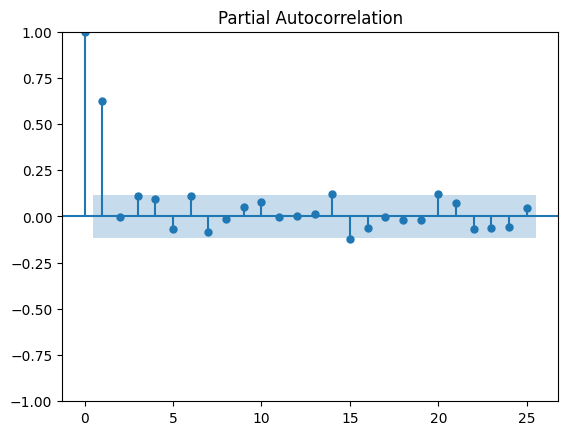

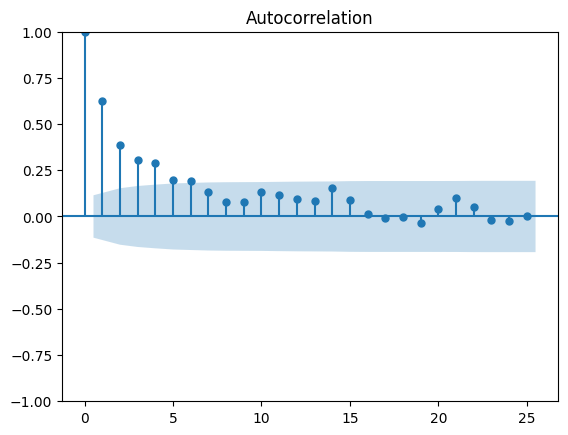

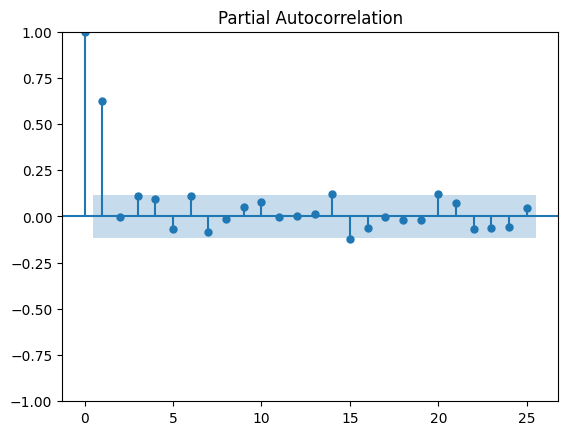

In [17]:
# Visualize autocorrelation using plot_acf
plot_acf(GWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(GWAP_train, lags=25, alpha=0.05)

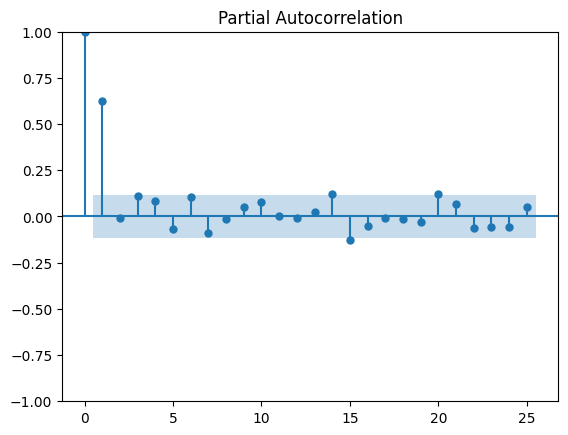

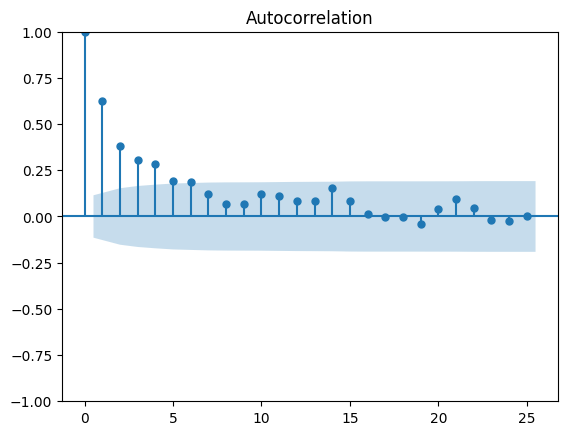

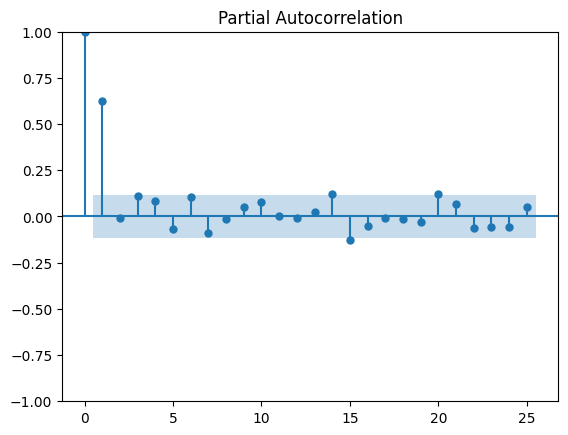

In [18]:

# Visualize autocorrelation using plot_acf
plot_acf(LWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LWAP_train, lags=25, alpha=0.05)

Forecast using statsmodels

In [19]:
#weekly seasonality
GWAP_sarimax_7 = auto_arima(GWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=6, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=diff_exog_train, iter=1000, method='powell')

 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-361.425, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-363.701, Time=0.87 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=-367.088, Time=1.43 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=-364.892, Time=0.83 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-366.473, Time=1.92 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=-365.445, Time=1.98 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=-368.965, Time=4.39 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=-365.667, Time=2.25 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=-467.580, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-466.282, Time=2.14 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=-471.820, Time=1.20 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=-466.514, Time=0.59 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=-474.250, Time=2.01 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=-472.537, Time=3.58 sec
 ARIMA(0,0,1)(2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -0.971272
         Iterations: 29
         Function evaluations: 8605


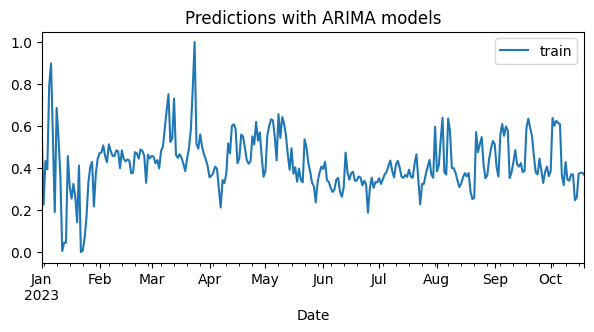

In [20]:
#Using statsmodels

gwap_model_weekly = SARIMAX(endog = GWAP_train, exog = diff_exog_train, order=(1, 0, 0), seasonal_order=(2,0,1,7))
fitted_gwap_model_weekly=gwap_model_weekly.fit(method='powell', maxiter=300)

gwap_train_predict = fitted_gwap_model_weekly.predict(start='2023-01-01', end='2023-10-19', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [21]:
fitted_gwap_model_weekly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                GWAP   No. Observations:                  292
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 7)   Log Likelihood                 283.611
Date:                             Fri, 15 Nov 2024   AIC                           -499.223
Time:                                     14:11:27   BIC                           -374.213
Sample:                                 01-01-2023   HQIC                          -449.149
                                      - 10-19-2023                                         
Covariance Type:                               opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
FLOW_MIN                   -0.0592      0.080     -0.737      0.461      -0.217       0.098
Hourly Demand              -0.0160      0.114     -0.139      0.889      -0.240       0.208
TMIN_Davao City            -0.0565      0.034     -1.667      0.095      -0.123       0.010
TMAX_Surigao               -0.0153      0.041     -0.373      0.709      -0.096       0.065
TMIN_Surigao                0.0291      0.032      0.897      0.370      -0.034       0.093
TMIN_Zamboanga             -0.0227      0.037     -0.607      0.544      -0.096       0.051
TMIN_Butuan                -0.0227      0.037     -0.617      0.537      -0.095       0.049
TMAX_Malaybalay            -0.0074      0.056     -0.133      0.894      -0.117       0.102
TMAX_General Santos         0.0683      0.059      1.163      0.245      -0.047       0.184
TMAX_Davao City             0.0100      0.031      0.324      0.746      -0.051       0.071
TMAX_Zamboanga             -0.0173      0.050     -0.345      0.730      -0.116       0.081
TMAX_Dipolog                0.0339      0.039      0.874      0.382      -0.042       0.110
TMIN_Dipolog               -0.0133      0.050     -0.267      0.790      -0.111       0.085
TMAX_Butuan                 0.0334      0.038      0.890      0.374      -0.040       0.107
TMIN_Malaybalay             0.0040      0.023      0.174      0.862      -0.041       0.049
TMAX_Cotabato               0.0588      0.044      1.331      0.183      -0.028       0.145
RESERVE_GWAP_Fr             0.0036      0.017      0.210      0.834      -0.030       0.037
RESERVE_GWAP_Ru            -0.0334      0.039     -0.862      0.389      -0.109       0.043
RESERVE_GWAP_Rd            -0.0104      0.026     -0.398      0.690      -0.061       0.041
RESERVE_GWAP_Dr            -0.0020      0.021     -0.095      0.924      -0.044       0.040
RAINFALL_Davao City        -0.0427      0.029     -1.461      0.144      -0.100       0.015
RAINFALL_Surigao           -0.0017      0.019     -0.086      0.931      -0.040       0.036
RAINFALL_Zamboanga         -0.0239      0.030     -0.805      0.421      -0.082       0.034
RAINFALL_Dipolog           -0.0005      0.018     -0.026      0.979      -0.037       0.036
RAINFALL_Butuan            -0.0043      0.019     -0.222      0.825      -0.042       0.033
RAINFALL_Malaybalay        -0.0136      0.018     -0.736      0.462      -0.050       0.023
RAINFALL_General Santos    -0.0208      0.027     -0.769      0.442      -0.074       0.032
TMIN_General Santos        -0.0473      0.045     -1.044      0.297      -0.136       0.041
RAINFALL_Cotabato           0.0410      0.022      1.879      0.060      -0.002       0.084
ar.L1                       0.7414      0.037     20.224      0.000       0.670       0.813
ar.S.L7                     0.7529      0.053     14.190      0.000       0.649       0.

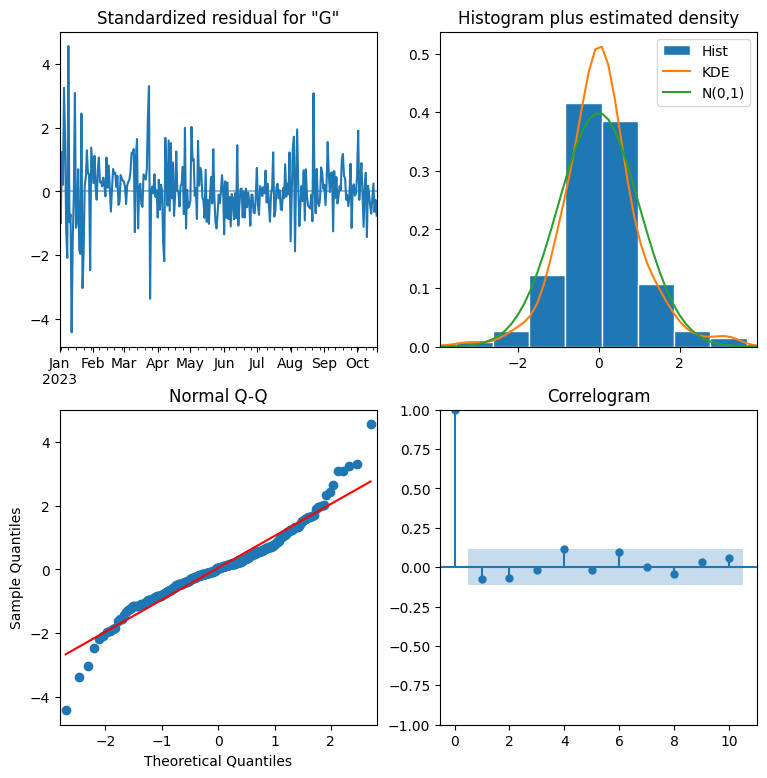

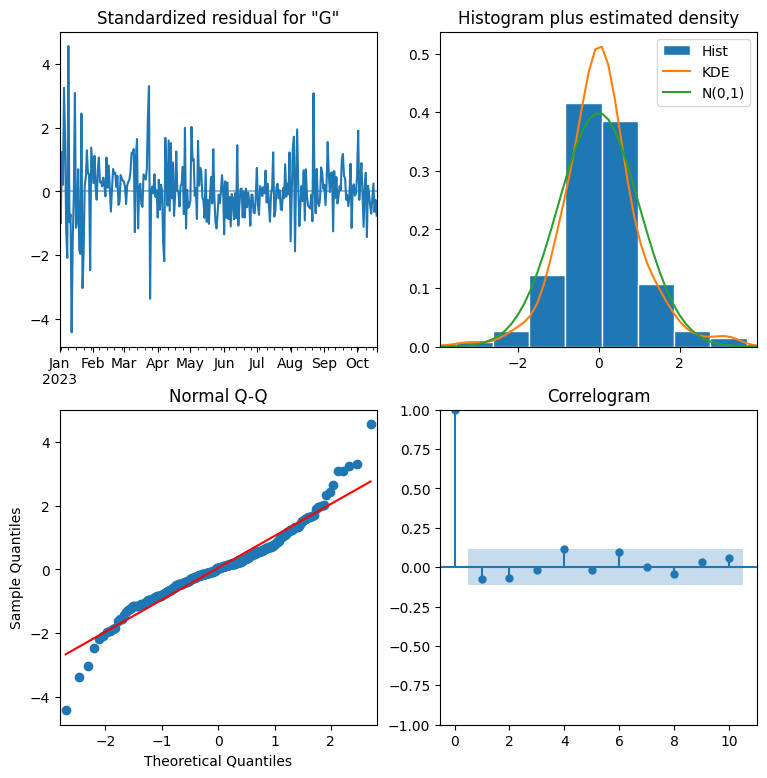

In [39]:
fitted_gwap_model_weekly.plot_diagnostics(figsize=(9,9))

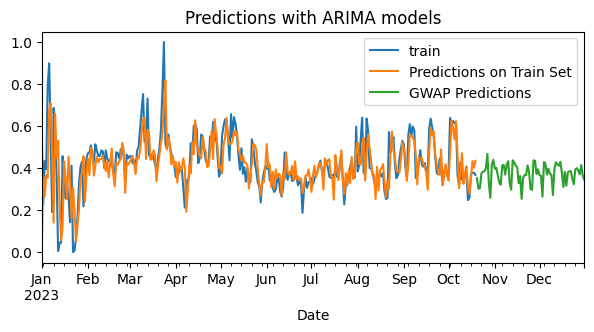

In [23]:
gwap_test_predict = fitted_gwap_model_weekly.predict(start='2023-10-20', end='2023-12-31', exog=diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
gwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
gwap_test_predict.plot(ax=ax, label='GWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [24]:
LWAP_sarimax_7 = auto_arima(LWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=6, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=diff_exog_train, iter=1000, method='powell')

 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-364.706, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-366.294, Time=0.27 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=-369.735, Time=0.30 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=-367.297, Time=0.27 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-369.008, Time=0.15 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=-367.719, Time=0.41 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=-371.454, Time=1.05 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=-367.887, Time=0.75 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=-471.296, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-469.815, Time=0.17 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=-475.423, Time=0.42 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=-469.987, Time=0.31 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=-477.125, Time=0.29 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=-475.469, Time=0.57 sec
 ARIMA(0,0,1)(2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -0.976645
         Iterations: 32
         Function evaluations: 9448


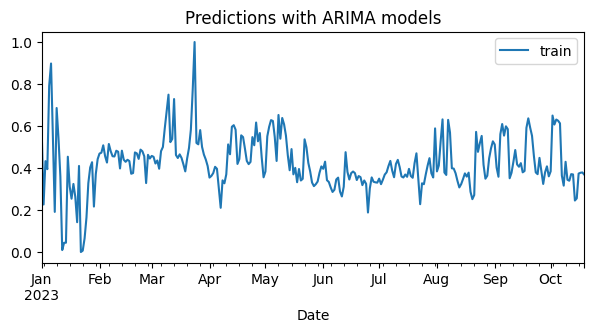

In [25]:
lwap_model_weekly = SARIMAX(endog = LWAP_train, exog = diff_exog_train, order=(1, 0, 0), seasonal_order=(2,0,1,7))
fitted_lwap_model_weekly=lwap_model_weekly.fit(method='powell', maxiter=300)
#Check fit on train set
lwap_train_predict = fitted_lwap_model_weekly.predict(start='2023-01-01', end='2023-10-19', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [26]:
fitted_lwap_model_weekly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                LWAP   No. Observations:                  292
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 7)   Log Likelihood                 285.180
Date:                             Fri, 15 Nov 2024   AIC                           -502.360
Time:                                     14:28:14   BIC                           -377.351
Sample:                                 01-01-2023   HQIC                          -452.287
                                      - 10-19-2023                                         
Covariance Type:                               opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
FLOW_MIN                   -0.0528      0.082     -0.641      0.522      -0.214       0.109
Hourly Demand              -0.0169      0.115     -0.147      0.883      -0.242       0.208
TMIN_Davao City            -0.0577      0.035     -1.664      0.096      -0.126       0.010
TMAX_Surigao               -0.0223      0.041     -0.543      0.587      -0.103       0.058
TMIN_Surigao                0.0270      0.033      0.819      0.413      -0.038       0.092
TMIN_Zamboanga             -0.0286      0.038     -0.750      0.453      -0.103       0.046
TMIN_Butuan                -0.0250      0.037     -0.676      0.499      -0.097       0.047
TMAX_Malaybalay             0.0063      0.055      0.114      0.909      -0.102       0.115
TMAX_General Santos         0.0781      0.059      1.322      0.186      -0.038       0.194
TMAX_Davao City             0.0143      0.031      0.457      0.648      -0.047       0.075
TMAX_Zamboanga             -0.0130      0.051     -0.256      0.798      -0.113       0.087
TMAX_Dipolog                0.0323      0.039      0.818      0.414      -0.045       0.110
TMIN_Dipolog               -0.0238      0.050     -0.471      0.637      -0.123       0.075
TMAX_Butuan                 0.0344      0.038      0.905      0.365      -0.040       0.109
TMIN_Malaybalay             0.0023      0.023      0.101      0.919      -0.043       0.048
TMAX_Cotabato               0.0554      0.044      1.257      0.209      -0.031       0.142
RESERVE_GWAP_Fr             0.0035      0.017      0.200      0.841      -0.030       0.037
RESERVE_GWAP_Ru            -0.0309      0.039     -0.796      0.426      -0.107       0.045
RESERVE_GWAP_Rd            -0.0099      0.026     -0.377      0.706      -0.061       0.041
RESERVE_GWAP_Dr            -0.0029      0.022     -0.131      0.896      -0.046       0.040
RAINFALL_Davao City        -0.0458      0.029     -1.560      0.119      -0.103       0.012
RAINFALL_Surigao           -0.0019      0.020     -0.096      0.924      -0.040       0.036
RAINFALL_Zamboanga         -0.0222      0.030     -0.736      0.462      -0.081       0.037
RAINFALL_Dipolog            0.0024      0.019      0.132      0.895      -0.034       0.039
RAINFALL_Butuan            -0.0071      0.020     -0.353      0.724      -0.046       0.032
RAINFALL_Malaybalay        -0.0132      0.019     -0.707      0.480      -0.050       0.023
RAINFALL_General Santos    -0.0215      0.027     -0.798      0.425      -0.074       0.031
TMIN_General Santos        -0.0439      0.046     -0.959      0.338      -0.134       0.046
RAINFALL_Cotabato           0.0387      0.022      1.768      0.077      -0.004       0.082
ar.L1                       0.7202      0.038     18.779      0.000       0.645       0.795
ar.S.L7                     0.7649      0.053     14.341      0.000       0.660       0.

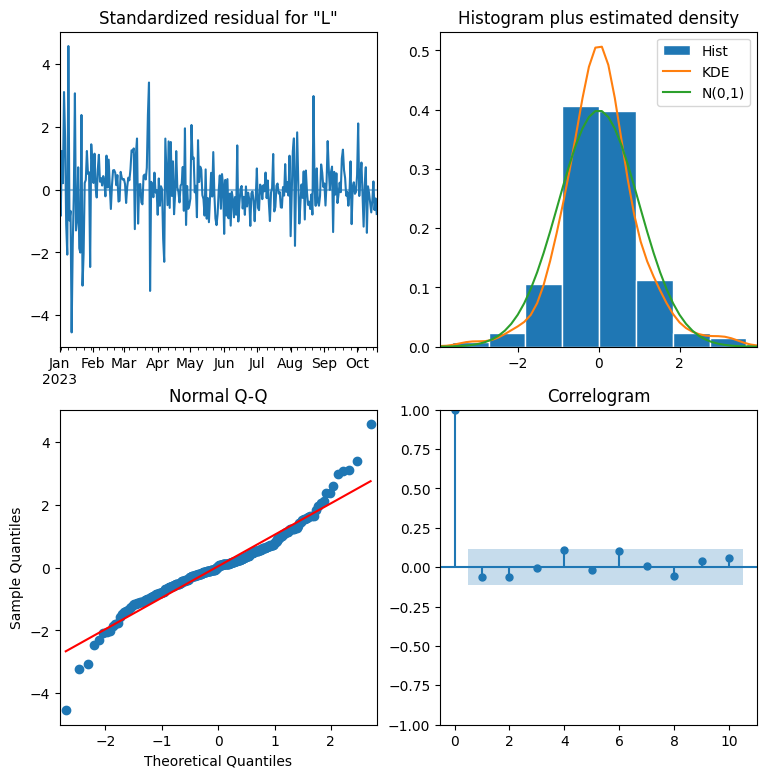

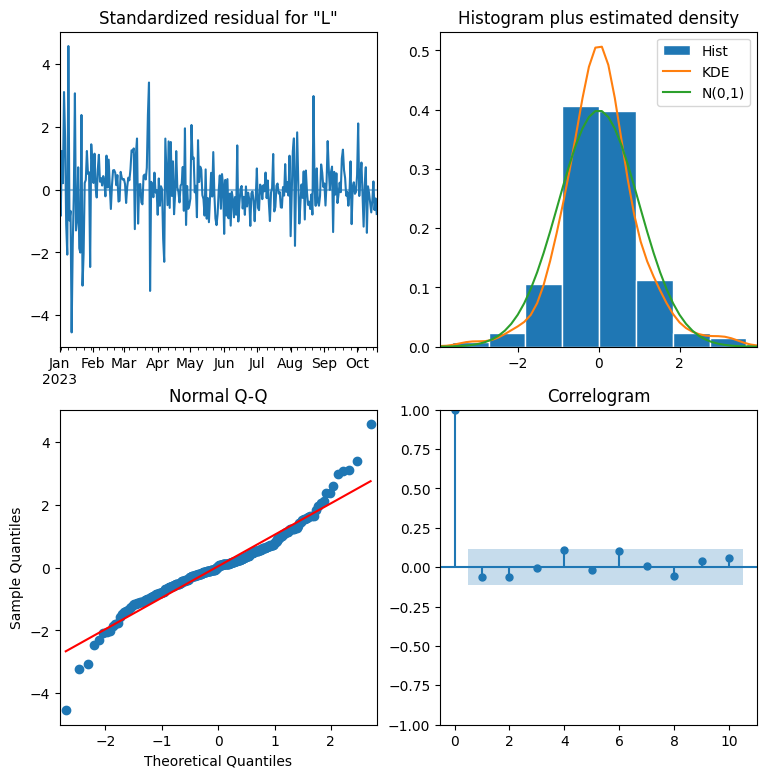

In [38]:
fitted_lwap_model_weekly.plot_diagnostics(figsize=(9,9))

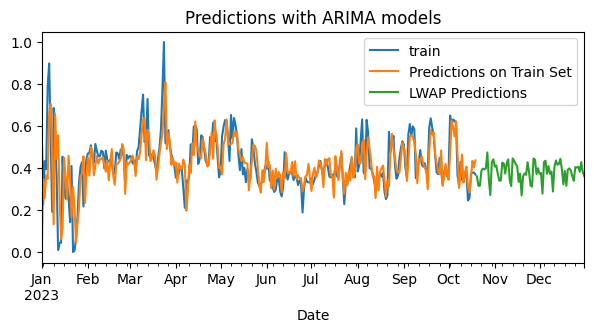

In [29]:
#Predict using LWAP mdodel and plot predictions
lwap_test_predict = fitted_lwap_model_weekly.predict(start='2023-10-20', end='2023-12-31', exog=diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
lwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
lwap_test_predict.plot(ax=ax, label='LWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

Rolling Forecast

In [60]:

def rolling_forecast(train, test, exog_train, exog_test, order, season):
    """
    Perform rolling forecast with SARIMAX model, including exogenous variables.
    
    Parameters:
    - train: Series or DataFrame containing the target variable for training.
    - test: Series or DataFrame containing the target variable for testing.
    - exog_train: DataFrame containing the exogenous variables for training.
    - exog_test: DataFrame containing the exogenous variables for testing.
    - order: Tuple (p, d, q) representing the AR, I, and MA terms.
    - season: Tuple (P, D, Q, S) representing the seasonal AR, I, and MA terms with the seasonal period.
    
    Returns:
    - results: Dictionary containing predictions, mse, rmse, and mae.
    """
    history = [x for x in train]  # Start with training data
    exog_history = exog_train.iloc[0:len(train)]  # Corresponding exogenous data for training
    model = SARIMAX(history, exog=exog_history, order=order, seasonal_order=season)
    model_fit = model.fit(disp=False, method='powell', maxiter=300)
    
    predictions = []
    results = {}
    
    # First forecast (out of sample) using the first test point
    exog_forecast = exog_test.iloc[0:1]  # First test point's exogenous variables
    yhat = model_fit.forecast(exog=exog_forecast)[0]
    
    predictions.append(yhat)
    history.append(test[0])  # Add the first test observation to the history
    exog_history = pd.concat([exog_history, exog_test.iloc[0:1]])  # Use concat instead of append
    
    # Rolling forecast loop
    for i in range(1, len(test)):
        model = SARIMAX(history, exog=exog_history, order=order, seasonal_order=season)
        model_fit = model.fit(disp=False, method='powell', maxiter=300)
        
        exog_forecast = exog_test.iloc[i:i+1]  # Current test point exogenous variables
        yhat = model_fit.forecast(exog=exog_forecast)[0]
        
        predictions.append(yhat)
        
        obs = test[i]  # Actual test value
        history.append(obs)  # Append to history
        
        # Concatenate new exogenous data with history
        exog_history = pd.concat([exog_history, exog_test.iloc[i:i+1]])  # Use concat instead of append
    
    # Convert predictions to a pandas Series
    predictions = pd.Series(predictions, index=test.index)
    
    # Store results
    results['predictions'] = predictions
    
    return results

In [ ]:
#Transform test set
test_transformed = boxcoxy_fit_loaded.transform(labels_test)
test_transformed = pd.DataFrame(test_transformed, columns = labels_columns)

GWAP_test_transformed = test_transformed['GWAP']
GWAP_test_transformed = pd.concat([test_date,GWAP_test_transformed], axis=1)
GWAP_test_transformed.set_index('Date', inplace=True)
GWAP_test_transformed.index = pd.to_datetime(GWAP_test_transformed.index)
GWAP_test_transformed.index.freq='D'
GWAP_test_transformed = GWAP_test_transformed.squeeze()

LWAP_test_transformed = test_transformed['LWAP']
LWAP_test_transformed = pd.concat([test_date,LWAP_test_transformed], axis=1)
LWAP_test_transformed.set_index('Date', inplace=True)
LWAP_test_transformed.index = pd.to_datetime(LWAP_test_transformed.index)
LWAP_test_transformed.index.freq='D'
LWAP_test_transformed = LWAP_test_transformed.squeeze()


In [61]:
gwap_rolling_predictions = rolling_forecast(GWAP_train, GWAP_test_transformed, diff_exog_train, diff_exog_test, order=(1, 0, 0), season=(2,0,1,7))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [ ]:
lwap_rolling_predictions = rolling_forecast(LWAP_train, LWAP_test_transformed, diff_exog_train, diff_exog_test, order=(1, 0, 0), season=(2,0,1,7))

Applying inverse transformations - non-rolling

In [32]:
all_predictions = pd.concat([gwap_test_predict, lwap_test_predict], axis=1)
all_predictions_inverse=boxcoxy_fit_loaded.inverse_transform(all_predictions)
all_predictions_inverse

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but PowerTransformer was fitted with feature names



array([[3505.74462872, 3832.97375285],
       [2719.23091174, 3073.43748722],
       [2768.10185036, 3079.0351083 ],
       [3869.81676654, 4303.34707662],
       [4032.91224991, 4501.96469374],
       [4050.64739307, 4440.75800479],
       [4280.94864966, 4525.20217266],
       [5620.98654019, 6062.37743404],
       [3139.67090445, 3572.62564097],
       [2108.1102005 , 2405.81670397],
       [4612.01112815, 5085.19527765],
       [5065.17685171, 5374.31802968],
       [4283.46178292, 4686.84682408],
       [4343.06562447, 4787.99685639],
       [3727.77222746, 4054.05138811],
       [3176.43569614, 3483.31605988],
       [3011.78753269, 3477.12353793],
       [4586.06451985, 5058.55410207],
       [4595.41280019, 4977.41974057],
       [3786.4749276 , 4070.72081583],
       [4648.02772845, 5002.34336885],
       [4935.77078987, 5371.72812146],
       [3103.99870973, 3541.63699704],
       [2661.09025936, 3053.4275202 ],
       [5025.4448352 , 5459.68911248],
       [4853.65696645, 52

In [33]:
all_predictions_inverse_df = pd.DataFrame(all_predictions_inverse)
all_predictions_inverse_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

GWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 0], columns=['GWAP'])
GWAP_predictions_inverse = pd.concat([test_date,GWAP_predictions_inverse], axis=1)
GWAP_predictions_inverse.set_index('Date', inplace=True)
GWAP_predictions_inverse.index = pd.to_datetime(GWAP_predictions_inverse.index)
GWAP_predictions_inverse.index.freq='D'
GWAP_predictions_inverse = GWAP_predictions_inverse.squeeze()

LWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 1], columns=['LWAP'])
LWAP_predictions_inverse = pd.concat([test_date,LWAP_predictions_inverse], axis=1)
LWAP_predictions_inverse.set_index('Date', inplace=True)
LWAP_predictions_inverse.index = pd.to_datetime(LWAP_predictions_inverse.index)
LWAP_predictions_inverse.index.freq='D'
LWAP_predictions_inverse = LWAP_predictions_inverse.squeeze()

Mean Absolute Error (MAE) on Test Set: 780.6408905174505
Root Mean Squared Error (RMSE) on Test Set: 1007.5075806136736


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



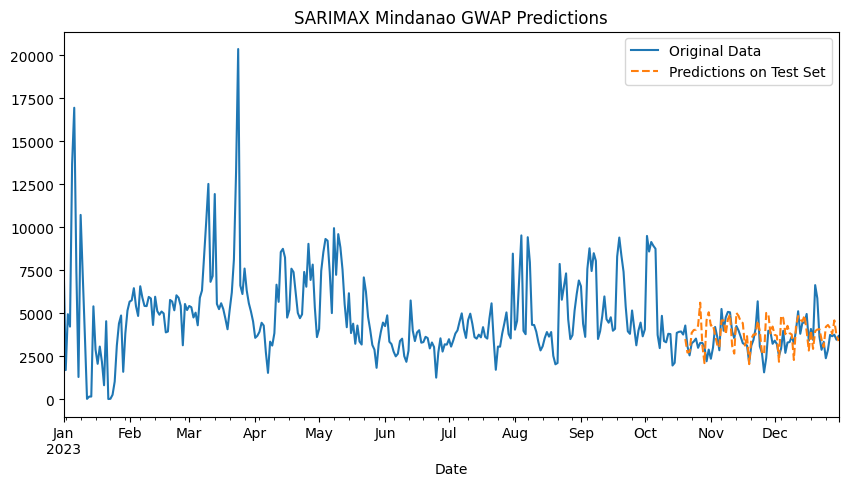

In [34]:
# Calculate MAE for the Mindanao GWAP test set
mae_test = mean_absolute_error(GWAP_test_inversed, GWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Mindanao GWAP test set
rmse_test = mean_squared_error(GWAP_test_inversed, GWAP_predictions_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
GWAP.plot(ax=ax, label='Original Data')
GWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Mindanao GWAP Predictions')
ax.legend()
plt.show()

Mean Absolute Error (MAE) on Test Set: 866.3282750057019
Root Mean Squared Error (RMSE) on Test Set: 1110.092709897528


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



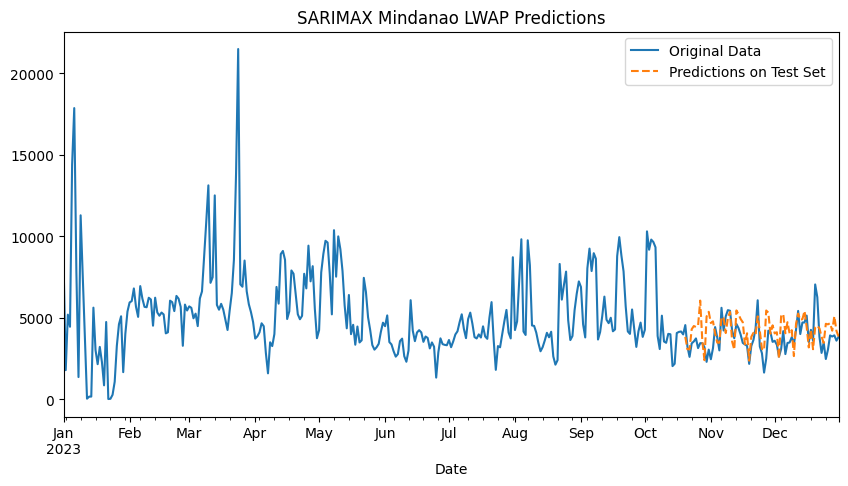

In [35]:
# Calculate MAE for the Mindanao LWAP test set
mae_test = mean_absolute_error(LWAP_test_inversed, LWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Mindanao GWAP test set
rmse_test = mean_squared_error(LWAP_test_inversed, LWAP_predictions_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original Data')
LWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Mindanao LWAP Predictions')
ax.legend()
plt.show()

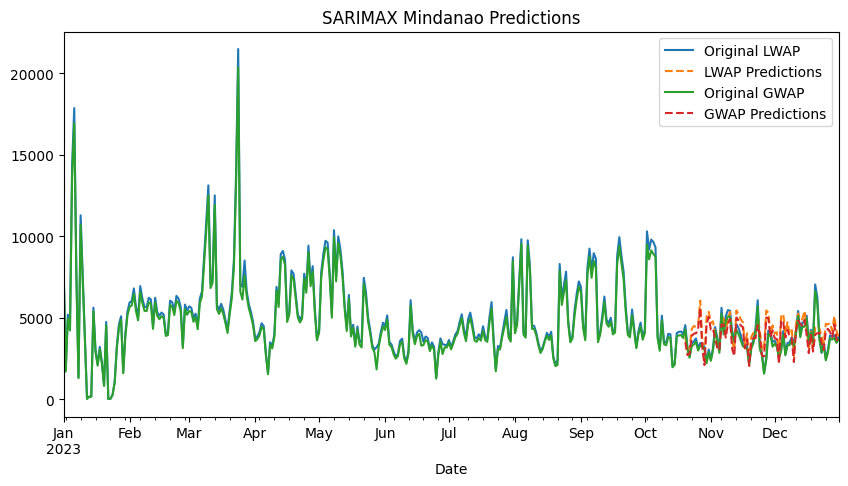

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original LWAP')
LWAP_predictions_inverse.plot(ax=ax, label='LWAP Predictions', linestyle='--')
GWAP.plot(ax=ax, label='Original GWAP')
GWAP_predictions_inverse.plot(ax=ax, label='GWAP Predictions', linestyle='--')
ax.set_title('SARIMAX Mindanao Predictions')
ax.legend()
plt.show()

In [37]:
GWAP_predictions_inverse.to_csv('min-gwap-predictions.csv', index=False)
LWAP_predictions_inverse.to_csv('min-lwap-predictions.csv', index=False)

Applying inverse transformations - rolling

In [ ]:
all_predictions_rolling = pd.concat([gwap_rolling_predictions, lwap_rolling_predictions], axis=1)
all_predictions_rolling_inverse=boxcoxy_fit_loaded.inverse_transform(all_predictions_rolling)
all_predictions_rolling_inverse

In [ ]:
all_predictions_rolling_inverse_df = pd.DataFrame(all_predictions_rolling_inverse)
all_predictions_rolling_inverse_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

GWAP_predictions_rolling_inverse = pd.DataFrame(all_predictions_rolling_inverse[:, 0], columns=['GWAP'])
GWAP_predictions_rolling_inverse = pd.concat([test_date,GWAP_predictions_rolling_inverse], axis=1)
GWAP_predictions_rolling_inverse.set_index('Date', inplace=True)
GWAP_predictions_rolling_inverse.index = pd.to_datetime(GWAP_predictions_rolling_inverse.index)
GWAP_predictions_rolling_inverse.index.freq='D'
GWAP_predictions_rolling_inverse = GWAP_predictions_inverse.squeeze()

LWAP_predictions_rolling_inverse = pd.DataFrame(all_predictions_rolling_inverse[:, 1], columns=['LWAP'])
LWAP_predictions_rolling_inverse = pd.concat([test_date,LWAP_predictions_rolling_inverse], axis=1)
LWAP_predictions_rolling_inverse.set_index('Date', inplace=True)
LWAP_predictions_rolling_inverse.index = pd.to_datetime(LWAP_predictions_rolling_inverse.index)
LWAP_predictions_rolling_inverse.index.freq='D'
LWAP_predictions_rolling_inverse = LWAP_predictions_rolling_inverse.squeeze()

In [ ]:
# Calculate MAE for the Mindanao GWAP test set
mae_test = mean_absolute_error(GWAP_test_inversed, GWAP_predictions_rolling_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Mindanao GWAP test set
rmse_test = mean_squared_error(GWAP_test_inversed, GWAP_predictions_rolling_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
GWAP.plot(ax=ax, label='Original Data')
GWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Mindanao GWAP Predictions')
ax.legend()
plt.show()

In [ ]:
# Calculate MAE for the Mindanao LWAP test set
mae_test = mean_absolute_error(LWAP_test_inversed, LWAP_predictions_rolling_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Mindanao GWAP test set
rmse_test = mean_squared_error(LWAP_test_inversed, LWAP_predictions_rolling_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original Data')
LWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Mindanao LWAP Predictions')
ax.legend()
plt.show()